# Azure Custom Vision - Image classification

This project leverages **Azure Custom Vision** to build and deploy a tailored image classification model.
We will build, train and deploy an image model classification to classify metal defects.
A gradio webapp is also available to predict the images.

## 🚀 Overview
**Azure Custom Vision** enables rapid creation of custom image classifiers using a simple web interface or API. It supports:
- **Multi-class classification**: Assigning one label per image.
- **Multi-label classification**: Assigning multiple labels per image.

## 🛠️ How It Works

- **Upload and Tag Images**: Use the portal or API to upload training images and assign tags.
- **Train the Model**: Azure uses transfer learning to train a model based on your dataset.
- **Evaluate Performance**: Review precision, recall, confusion matrix and accuracy metrics.
- **Deploy**: Publish the model as a REST API or export it for offline use (Onnx, Docker, TensorFlow, CoreML).

## 📚 Resources
- https://learn.microsoft.com/en-us/azure/ai-services/custom-vision-service/overview
- https://learn.microsoft.com/en-us/azure/ai-services/custom-vision-service/getting-started-build-a-classifier

### Azure Custom Vision

https://www.customvision.ai

<img src="screenshot1.jpg">

In [1]:
#%pip install azure-cognitiveservices-vision-customvision

In [2]:
import datetime
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys
import time

from azurecv import AzureCustomVisionImageClassifier
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from dotenv import load_dotenv
from IPython.display import display
from msrest.authentication import ApiKeyCredentials
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont

In [3]:
sys.version

'3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]'

In [4]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 14-Sep-2025 13:23:22


## 1. Settings

In [5]:
load_dotenv("azure.env")

training_endpoint = os.environ["training_endpoint"]  # Training endpoint for Azure Custom Vision 
prediction_endpoint = os.environ["prediction_endpoint"]  # Prediction endpoint for Azure Custom Vision 
training_key = os.environ["training_key"]  # Training key for Azure Custom Vision 
prediction_key = os.environ["prediction_key"]  # Prediction key for Azure Custom Vision 
prediction_resource_id = os.environ["prediction_resource_id"]  # Prediction resource id 

In [6]:
classifier = AzureCustomVisionImageClassifier(
    training_endpoint=training_endpoint,
    prediction_endpoint=prediction_endpoint,
    training_key=training_key,
    prediction_key=prediction_key,
    prediction_resource_id=prediction_resource_id
)

In [7]:
project_name = "metal-classification"  # Project to create
description = "Metal classification demo using Azure AI Custom Vision"  # Project description

In [8]:
OUTPUT_DIR = "results"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [9]:
IMAGES_DIR = "images"

TRAIN_DIR = os.path.join(IMAGES_DIR, "train")
TEST_DIR = os.path.join(IMAGES_DIR, "test")

os.makedirs(IMAGES_DIR, exist_ok=True)

## 2. Images

In [10]:
HOME_DIR = os.getcwd()

### Downloading the images

In [11]:
train_images1_zip = "https://raw.githubusercontent.com/retkowsky/image-classification-azure-custom-vision/refs/heads/main/zip/train1.zip"
train_images2_zip = "https://raw.githubusercontent.com/retkowsky/image-classification-azure-custom-vision/refs/heads/main/zip/train2.zip"
test_images_zip = "https://raw.githubusercontent.com/retkowsky/image-classification-azure-custom-vision/refs/heads/main/zip/test.zip"

In [12]:
os.chdir(IMAGES_DIR)

print("Downloading the files...\n")
print("Downloading training datasets...")
!wget $train_images1_zip
!wget $train_images2_zip
print("Downloading test dataset...")
!wget $test_images_zip
print("Done")


--2025-09-14 13:23:32--  https://raw.githubusercontent.com/retkowsky/image-classification-azure-custom-vision/refs/heads/main/zip/train1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14989494 (14M) [application/zip]
Saving to: ‘train1.zip’

train1.zip          100%[===================>]  14.29M  --.-KB/s    in 0.08s   

2025-09-14 13:23:33 (178 MB/s) - ‘train1.zip’ saved [14989494/14989494]

--2025-09-14 13:23:33--  https://raw.githubusercontent.com/retkowsky/image-classification-azure-custom-vision/refs/heads/main/zip/train2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.


In [13]:
# Unzipping the files in a quiet mode
print("Unzipping the files...\n")
print("Unzipping training images dataset. Please wait.")
!unzip -q "train1.zip"
!unzip -q "train2.zip"
print("Done\n")
print("Unzipping test images dataset. Please wait.")
!unzip -q "test.zip"
print("Done")

Unzipping the files...

Unzipping training images dataset. Please wait.
Done

Unzipping test images dataset. Please wait.
Done


In [14]:
print("Removing all the zip files...\n")
os.remove("train1.zip")
os.remove("train2.zip")
os.remove("test.zip")
print("Done")

Removing all the zip files...

Done


In [15]:
os.chdir(HOME_DIR)

### Our images

In [16]:
os.listdir(IMAGES_DIR)

['test', 'train']

In [17]:
os.listdir(TRAIN_DIR)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

In [18]:
image_extensions = {".jpg", ".jpeg", ".png", ".gif", ".bmp"}
nb_images = 0

for root, _, files in os.walk(TRAIN_DIR):
    nb = sum(1 for file in files
             if os.path.splitext(file)[1].lower() in image_extensions)
    if nb > 0:
        print(f"{root}\t = {nb} images")
    nb_images += nb

print(f"\n>> Total of training images files = {nb_images}")

images/train/Crazing	 = 200 images
images/train/Inclusion	 = 200 images
images/train/Patches	 = 200 images
images/train/Pitted	 = 200 images
images/train/Rolled	 = 200 images
images/train/Scratches	 = 200 images

>> Total of training images files = 1200



images/train/Crazing - showing first 5 image(s)


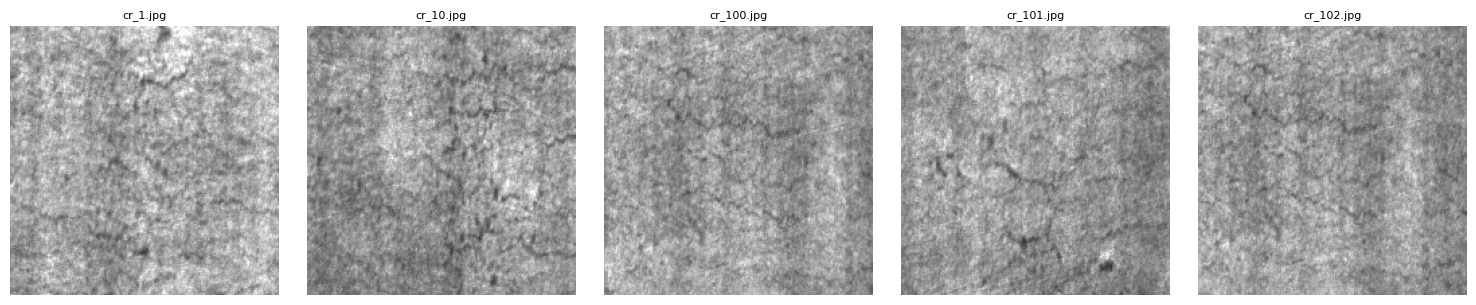


images/train/Inclusion - showing first 5 image(s)


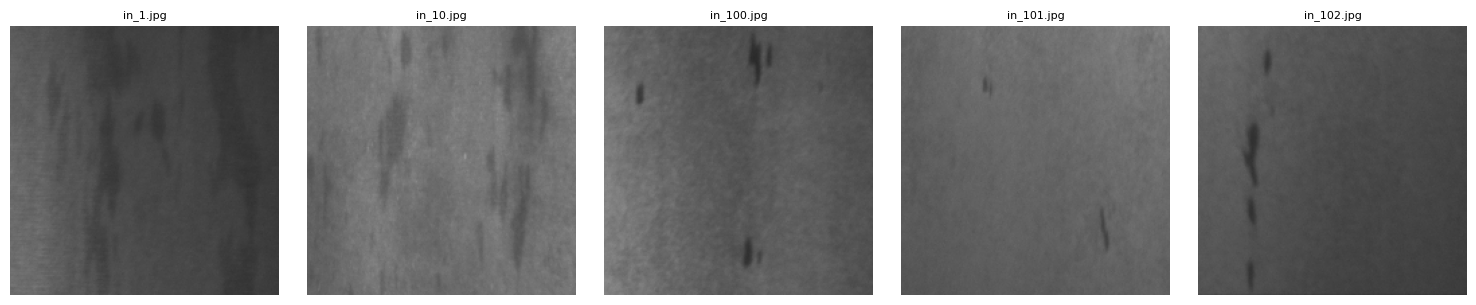


images/train/Patches - showing first 5 image(s)


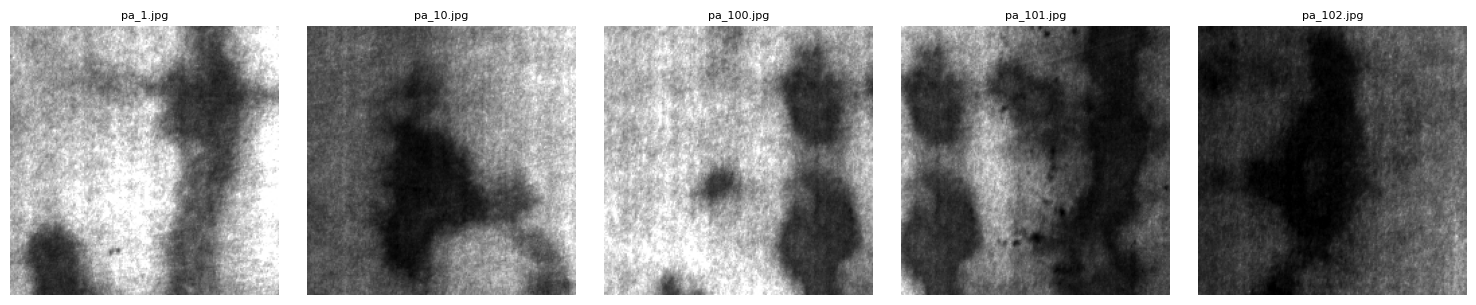


images/train/Pitted - showing first 5 image(s)


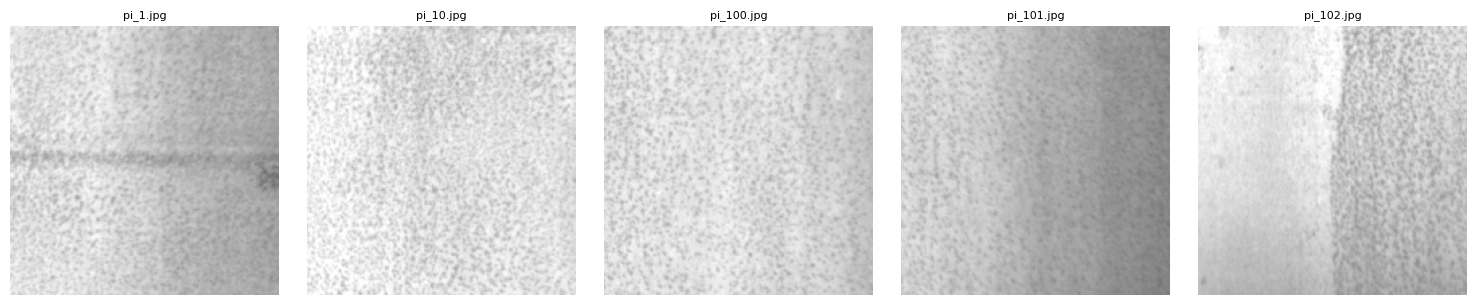


images/train/Rolled - showing first 5 image(s)


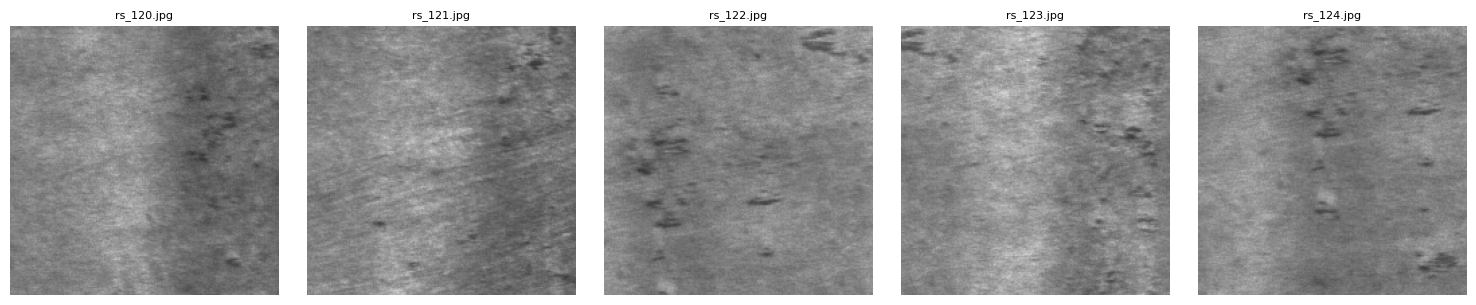


images/train/Scratches - showing first 5 image(s)


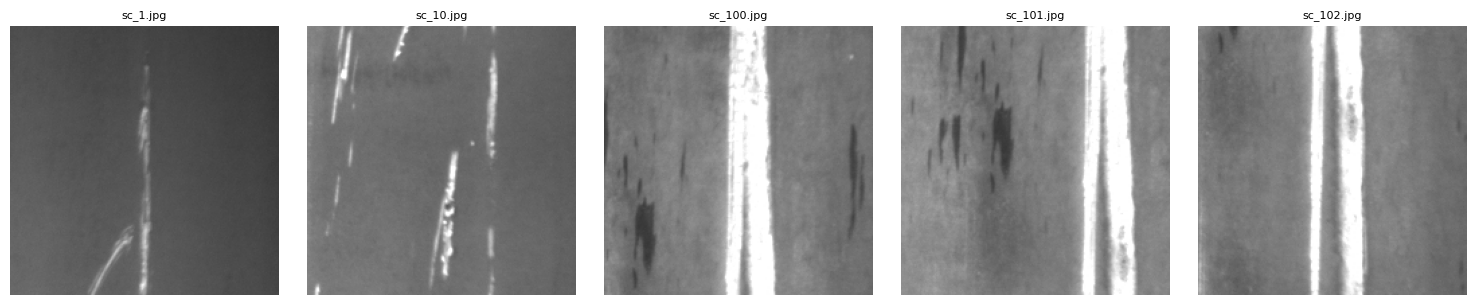

In [19]:
directory = Path(TRAIN_DIR)

for subdir, _, files in os.walk(directory):
    subdir_path = Path(subdir)
    image_files = [
        subdir_path / f for f in files
        if Path(f).suffix.lower() in image_extensions
    ]
    if image_files:
        print(f"\n{subdir} - showing first {min(5, len(image_files))} image(s)")

        fig, axes = plt.subplots(1, min(5, len(image_files)), figsize=(15, 3))
        if len(image_files) == 1:
            axes = [axes]

        for ax, img_path in zip(axes, image_files[:5]):
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.set_title(img_path.name, fontsize=8)
            ax.axis("off")

        plt.tight_layout()
        plt.show()

## 3. Creating Azure Custom Vision project

In [20]:
classifier

In [21]:
classifier.create_project(project_name, description=description)

🛠️ Creating project: metal-classification
Using domain: General [A2]

✅ Project created with ID: c7989390-651a-4a1f-a68c-466b8b45d6ab


## 4. Creating tags

In [22]:
tag_names = os.listdir(TRAIN_DIR)
print(f"Number of tags = {len(tag_names)}\n")

print(f"🏷️ Creating the tags for the {project_name} project...\n")
tags = classifier.create_tags(tag_names)
print("\nDone")

Number of tags = 6

🏷️ Creating the tags for the metal-classification project...

✅ Created tag: Crazing
✅ Created tag: Inclusion
✅ Created tag: Patches
✅ Created tag: Pitted
✅ Created tag: Rolled
✅ Created tag: Scratches

Done


## 5. Uploading images

In [23]:
training_data_folders = {
    "Crazing": f"{TRAIN_DIR}/Crazing",
    "Inclusion": f"{TRAIN_DIR}/Inclusion",
    "Patches": f"{TRAIN_DIR}/Patches",
    "Pitted": f"{TRAIN_DIR}/Pitted",
    "Rolled": f"{TRAIN_DIR}/Rolled",
    "Scratches": f"{TRAIN_DIR}/Scratches",
}

print(f"⬆️ Uploading the images into the {project_name} project...\n")
start = time.time()

for tag_name, folder_path in training_data_folders.items():
    if os.path.exists(folder_path):
        classifier.upload_images_from_folder(folder_path, tag_name, tags)
    else:
        print(f"❌ Folder not found: {folder_path}")

minutes, seconds = divmod((time.time() - start), 60)
print("Done")
print(f"Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

⬆️ Uploading the images into the metal-classification project...

✅ Uploaded batch of 64 images for tag 'Crazing'
✅ Uploaded batch of 64 images for tag 'Crazing'
✅ Uploaded batch of 64 images for tag 'Crazing'
✅ Uploaded batch of 8 images for tag 'Crazing'
Total images uploaded for 'Crazing' = 200

✅ Uploaded batch of 64 images for tag 'Inclusion'
✅ Uploaded batch of 64 images for tag 'Inclusion'
✅ Uploaded batch of 64 images for tag 'Inclusion'
✅ Uploaded batch of 8 images for tag 'Inclusion'
Total images uploaded for 'Inclusion' = 200

✅ Uploaded batch of 64 images for tag 'Patches'
✅ Uploaded batch of 64 images for tag 'Patches'
✅ Uploaded batch of 64 images for tag 'Patches'
✅ Uploaded batch of 8 images for tag 'Patches'
Total images uploaded for 'Patches' = 200

✅ Uploaded batch of 64 images for tag 'Pitted'
✅ Uploaded batch of 64 images for tag 'Pitted'
✅ Uploaded batch of 64 images for tag 'Pitted'
✅ Uploaded batch of 8 images for tag 'Pitted'
Total images uploaded for 'Pitted' 

## 6. Training the model (simple training)

In [24]:
iteration_name = "Iteration1"

delay_status_message = 30  # Display a status message every 30 secs

start = time.time()

iteration = classifier.train_model_regular(iteration_name, delay_status_message)

h, rem = divmod((time.time() - start), 3600)
m, s = divmod(rem, 60)
print(f"\nElapsed time = {int(h)} hours, {int(m)} minutes and {int(s)} seconds")

🧠 Starting regular training...

⏳ 2025-09-14 13:26:48 Training status: Training
⏳ 2025-09-14 13:27:18 Training status: Training
⏳ 2025-09-14 13:27:48 Training status: Training
⏳ 2025-09-14 13:28:18 Training status: Training
⏳ 2025-09-14 13:28:48 Training status: Training
⏳ 2025-09-14 13:29:18 Training status: Training
⏳ 2025-09-14 13:29:48 Training status: Training
⏳ 2025-09-14 13:30:18 Training status: Training
⏳ 2025-09-14 13:30:48 Training status: Training
⏳ 2025-09-14 13:31:19 Training status: Training
⏳ 2025-09-14 13:31:49 Training status: Training
⏳ 2025-09-14 13:32:19 Training status: Training
⏳ 2025-09-14 13:32:49 Training status: Training
⏳ 2025-09-14 13:33:19 Training status: Training
⏳ 2025-09-14 13:33:49 Training status: Training
⏳ 2025-09-14 13:34:19 Training status: Training
⏳ 2025-09-14 13:34:49 Training status: Training
⏳ 2025-09-14 13:35:19 Training status: Training
⏳ 2025-09-14 13:35:49 Training status: Completed

✅ Training completed!
Iteration ID: 29363b52-9224-4e8b

## 7. Advanced Training

In [25]:
iteration_name = "Iteration2"

delay_status_message = 300  # Display a message every 300 secs
nb_hours_max = 2  # 2 hours max of training
notification_email = ""  # Automatic email notification

start = time.time()

iteration = classifier.train_model_advanced(iteration_name,
                                            delay_status_message, nb_hours_max,
                                            notification_email)

h, rem = divmod((time.time() - start), 3600)
m, s = divmod(rem, 60)
print(f"\nElapsed time = {int(h)} hours, {int(m)} minutes and {int(s)} seconds")

🧠 Starting advanced training...

⏳ 2025-09-14 13:36:20 Training status: Training
⏳ 2025-09-14 13:41:20 Training status: Training
⏳ 2025-09-14 13:46:20 Training status: Training
⏳ 2025-09-14 13:51:21 Training status: Training
⏳ 2025-09-14 13:56:21 Training status: Training
⏳ 2025-09-14 14:01:21 Training status: Training
⏳ 2025-09-14 14:06:21 Training status: Training
⏳ 2025-09-14 14:11:22 Training status: Training
⏳ 2025-09-14 14:16:22 Training status: Training
⏳ 2025-09-14 14:26:22 Training status: Completed

✅ Training completed!
Iteration ID: d04c61f7-17d7-4400-9705-9b3a4dcc4d4d

Elapsed time = 0 hours, 55 minutes and 3 seconds


## 8. Azure Custom Vision project information

In [26]:
classifier.get_project_info()


🧠 Azure Custom Vision project: metal-classification
📝 Description: Metal classification demo using Azure AI Custom Vision
🧾Project ID: c7989390-651a-4a1f-a68c-466b8b45d6ab

🏷️ Tags (6):
  - Crazing (ID: b42257ae-d4d4-40ce-b56c-9a89f4f9a7d5)
  - Patches (ID: f4e57bc7-d484-4310-b46d-c48ec3cccaf0)
  - Rolled (ID: f89d3735-a521-46ba-8254-cad5762cbabe)
  - Pitted (ID: 88ad6093-816f-4dec-baa7-cdab69d632a4)
  - Inclusion (ID: 3f5ad3c0-e061-494d-81fa-e20ac496d132)
  - Scratches (ID: cf51aebe-5fed-47ac-bc49-e9919ffe5846)

🔁 Iterations (2):
  - 📰 Iteration 2: Completed (Not Published)
  - 📰 Iteration 1: Completed (Not Published)


## 9. Model performance metrics

In [27]:
# Get performance metrics for the latest iteration
print("\033[1;31;34m")
metrics = classifier.get_model_performance_metrics()

# Compare all iterations to find the best one
comparison = classifier.compare_model_iterations()

# Get detailed evaluation and save to file
eval_file = os.path.join(OUTPUT_DIR, f"{project_name}_evaluation.json")
detailed_evaluation = classifier.get_detailed_model_evaluation(export_to_file=eval_file)



Getting performance metrics for iteration: Iteration 1
Iteration ID: 29363b52-9224-4e8b-8ebf-031c45cfb186
Training completed: 2025-09-14 13:25:31.763000+00:00

🚀 Model Performance Metrics

OVERALL PERFORMANCE:
├── Precision =           0.99583 (99.58%)
├── Recall =              0.99583 (99.58%)
└── mAP (Avg Precision) = 0.99993 (99.99%)
    F1-Score =            0.9958 (99.58%)

PER-TAG PERFORMANCE:
------------------------------------------------------------
Tag Name        Precision    Recall       mAP          F1-Score    
------------------------------------------------------------
Crazing         1.00000      1.00000      1.00000      1.00000
Inclusion       1.00000      1.00000      1.00000      1.00000
Patches         0.97561      1.00000      1.00000      0.98765
Pitted          1.00000      0.97500      1.00000      0.98734
Rolled          1.00000      1.00000      1.00000      1.00000
Scratches       1.00000      1.00000      1.00000      1.00000


Comparing 2 completed ite

In [28]:
!ls $eval_file -lh

-rwxrwxrwx 1 root root 2.3K Sep 14 14:32 results/metal-classification_evaluation.json


## 10. Publishing the model

In [30]:
model_to_publish = "Iteration2"

classifier.publish_model(iteration,
                         model_to_publish,
                         prediction_resource_id=prediction_resource_id)

✅ Model published as: Iteration2


## 11. Confusion matrix

In [31]:
test_data_folders = {
    "Crazing": os.path.join(TEST_DIR, "Crazing"),
    "Inclusion": os.path.join(TEST_DIR, "Inclusion"),
    "Patches": os.path.join(TEST_DIR, "Patches"),
    "Pitted": os.path.join(TEST_DIR, "Pitted"),
    "Rolled": os.path.join(TEST_DIR, "Rolled"),
    "Scratches": os.path.join(TEST_DIR, "Scratches"),
}

# Generate confusion matrix
cm_file = os.path.join(OUTPUT_DIR, f"{project_name}_confusion_matrix.png")

confusion_data = classifier.generate_confusion_matrix(
    test_images_folder=test_data_folders,
    threshold=0.5,
    save_plot=True,
    plot_filename=cm_file,
)

# Analyze misclassifications
misclass_analysis = classifier.analyze_misclassifications(confusion_data, top_n=5)
print("Done\n")

Generating confusion matrix for 6 classes: ['Crazing', 'Patches', 'Rolled', 'Pitted', 'Inclusion', 'Scratches']
🔄 Processing 30 images from Crazing folder...
🔄 Processing 30 images from Inclusion folder...
🔄 Processing 30 images from Patches folder...
🔄 Processing 30 images from Pitted folder...
🔄 Processing 30 images from Rolled folder...
🔄 Processing 30 images from Scratches folder...
🛠️ Generated predictions for 180 images

CONFUSION MATRIX
🎯 Overall Accuracy: 0.9611 (96.11%)
Total Test Images: 180
   Crazing Inclusion   Patches    Pitted    Rolled Scratches   Unknown | Total
---------------------------------------------------------------------------------------------
Crazing                30         0         0         0         0         0         0 | 30
Inclusion               0        24         3         0         1         1         1 | 30
Patches                 0         0        30         0         0         0         0 | 30
Pitted                  0         0         0  

In [32]:
!ls $cm_file -lh

-rwxrwxrwx 1 root root 86K Sep 14 14:36 results/metal-classification_confusion_matrix.png


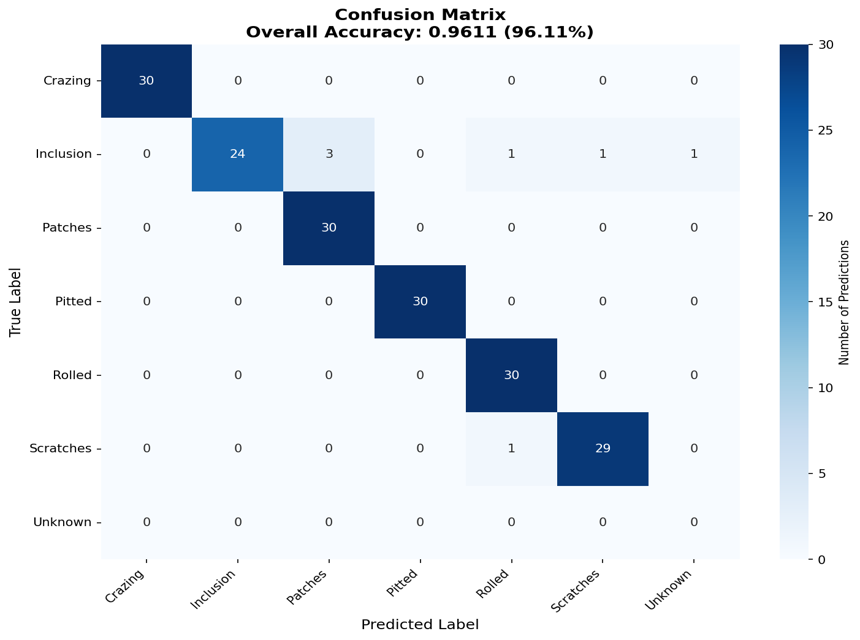

In [33]:
display(Image.open(cm_file).resize((860, 640)))

### Azure Custom Vision UI

<img src="screenshot2.jpg">

## 12. Predictions

In [34]:
def get_random_test_image(mydir):
    """
    Recursively searches for image files within the specified root directory and returns a randomly selected image path.

    Parameters:
        mydir (str): The root directory to begin the recursive search for image files.

    Returns:
        str or None: The full path to a randomly selected image file if any are found; otherwise, None.
    """
    image_extensions = {".jpg", ".jpeg", ".png", ".gif", ".bmp"}
    all_test_images = []
    
    for root, dirs, files in os.walk(mydir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                all_test_images.append(os.path.join(root, file))
    
    return random.choice(all_test_images) if all_test_images else None

In [35]:
def get_predictions(image_file):
    """
    Get predictions from the deployed model
        Args: Image file
        Returns: Tag and score
    """
    try:
        print(f"📷 Processing Image: {image_file}\n")
        img = Image.open(image_file).convert("RGB")
        display(img)

        predictions = classifier.predict_image_from_file(image_file)
        top_pred = predictions[0]
        tag = top_pred['tag'].upper()
        prob = top_pred['probability']
        print(f"\n🔍 Prediction: {tag} = {prob:.2%}\n")

        draw = ImageDraw.Draw(img)
        try:
            font = ImageFont.truetype("arial.ttf", 24)
        except IOError:
            font = ImageFont.load_default()
        
        text = f"{tag} ({prob:.2%})"
        draw.text((10, 10), text, fill=(0, 255, 255), font=font)
        display(img)
        return tag, prob
        
    except Exception as e:
        print(f"❌ Error processing image: {e}")
        return None

📷 Processing Image: images/test/Inclusion/in_263.jpg



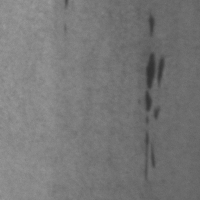


🔍 Prediction: INCLUSION = 99.86%



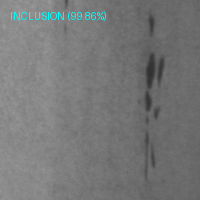

('INCLUSION', 0.9985759)

In [36]:
get_predictions(get_random_test_image(TEST_DIR))

📷 Processing Image: images/test/Inclusion/in_260.jpg



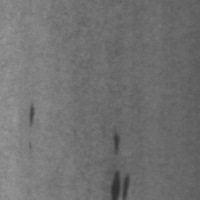


🔍 Prediction: INCLUSION = 99.98%



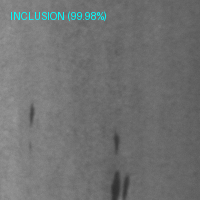

('INCLUSION', 0.9998363)

In [37]:
get_predictions(get_random_test_image(TEST_DIR))

📷 Processing Image: images/test/Inclusion/in_263.jpg



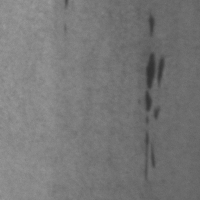


🔍 Prediction: INCLUSION = 99.86%



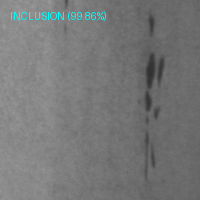

('INCLUSION', 0.9985759)

In [38]:
get_predictions(get_random_test_image(TEST_DIR))

📷 Processing Image: images/test/Pitted/pi_252.jpg



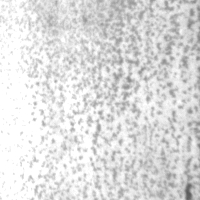


🔍 Prediction: PITTED = 100.00%



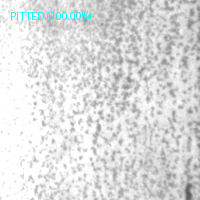

('PITTED', 0.99999774)

In [39]:
get_predictions(get_random_test_image(TEST_DIR))

📷 Processing Image: images/test/Pitted/pi_260.jpg



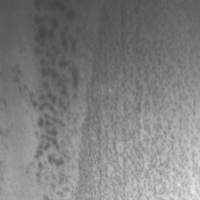


🔍 Prediction: PITTED = 100.00%



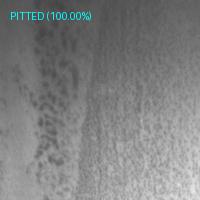

('PITTED', 1.0)

In [40]:
get_predictions(get_random_test_image(TEST_DIR))

📷 Processing Image: images/test/Pitted/pi_247.jpg



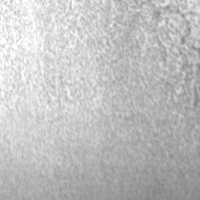


🔍 Prediction: PITTED = 100.00%



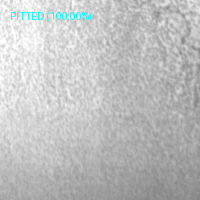

('PITTED', 0.99999285)

In [41]:
get_predictions(get_random_test_image(TEST_DIR))

📷 Processing Image: images/test/Pitted/pi_270.jpg



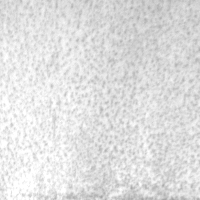


🔍 Prediction: PITTED = 100.00%



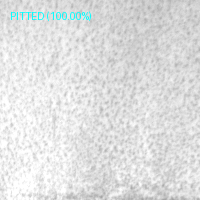

('PITTED', 0.9999993)

In [42]:
get_predictions(get_random_test_image(TEST_DIR))

### Azure Custom Vision ui

<img src="screenshot3.jpg">